In [2]:
%load_ext autoreload
%autoreload 2
from autoseg.datasets import get_dataset_path
from autoseg.config import read_config
from autoseg.models import Model
import zarr
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import functools
import gunpowder as gp
from gunpowder.nodes.add_affinities import seg_to_affgraph

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
def get_gt_affs(labels):
  nhood =  [[-1,0,0],
          [0,-1,0],
          [0,0,-1]]
  print(labels.shape)
  affs = seg_to_affgraph(labels, nhood).transpose(1, 2, 3, 0)
  print(affs.shape)
  return (affs * 255).astype(np.uint64)

  

In [14]:
@functools.cache
def get_sample_affs(config, shape_inc=(0,0,0)):
  shape_inc = list(shape_inc)
  config = read_config(config)
  model = Model(config)
  model.load(checkpoint="step-200000")
  model.to("cuda")

  zarr_ = zarr.open(get_dataset_path("SynapseWeb/kh2015/oblique"))
  img_arr = zarr_["raw"]["s1"][:]
  label_arr = zarr_["labels"]["s1"][:]

  image_shape = config["model"]["input_image_shape"]
  for i, s in enumerate(shape_inc):
    image_shape[i] += s
  start = [
    45 - image_shape[0] // 2,
    1400 - image_shape[1] // 2,
    1400 - image_shape[2] // 2
  ]
  sample_image = img_arr[
    start[0]:start[0]+image_shape[0],
    start[1]:start[1]+image_shape[1],
    start[2]:start[2]+image_shape[2],
  ]
  print(img_arr.shape)
  print(label_arr.shape)
  sample_labels = label_arr[
    start[0]:start[0]+image_shape[0],
    start[1]:start[1]+image_shape[1],
    start[2]:start[2]+image_shape[2],
  ]
  #sample_image = img_arr[10:10+image_shape[0], 1500:1500+image_shape[1], 1500:1500+image_shape[2]]

  inp = torch.tensor(sample_image)
  inp = ((inp / 255) * 2 - 1).float()
  out = model(inp.unsqueeze(0).unsqueeze(0).to("cuda"))
  affs = out[0]

  sample_affs = affs[0].detach().cpu().numpy().transpose(1, 2, 3, 0)
  del model
  del affs
  del out
  del inp
  return sample_image, (sample_affs * 255).astype(np.uint8), get_gt_affs(sample_labels)

In [15]:
def compare_models(configs):
  raws = []
  affss = []
  for config, label, inc_shape in configs:
    inc_shape = tuple(inc_shape)
    print(inc_shape)
    raw, affs, gt = get_sample_affs(config, inc_shape)
    raws.append(raw)
    affss.append(affs)
  
  # get smallest shape
  smallest_shape = [0,0,1000000]
  for img in raws + affss:
    shape = img.shape
    if shape[-1] < smallest_shape[-1]:
      smallest_shape = shape
  print(smallest_shape)
  
  # crop to same size, assume center is same among all images
  for imgs in [raws, affss]:
    for i, img in enumerate(imgs):
      if not img.shape == smallest_shape:
        img = img[
          img.shape[0]//2 - smallest_shape[0]//2:img.shape[0]//2 + smallest_shape[0]//2,
          img.shape[1]//2 - smallest_shape[1]//2:img.shape[1]//2 + smallest_shape[1]//2,
          img.shape[2]//2 - smallest_shape[2]//2:img.shape[2]//2 + smallest_shape[2]//2,
        ]
        imgs[i] = img


  fig, axs = plt.subplots(3 + len(configs), 4, figsize=(5, 10))
  for j, z in enumerate([0, 10, 20]):
    j += 1
    for row in [0, len(configs) + 1]:
      ax = axs[row,0]
      ax.text(0,0,"Raw Image")
      ax.axis("off")

      ax = axs[row,j]
      ax.axis("off")
      ax.imshow(raws[0][z], cmap="gray")

      ax = axs[row, 1]
      ax.text(0,0,"Ground Truth Affinities")
      ax.axis("off")

      ax = axs[row,j]
      ax.axis("off")
      ax.imshow(gt[z])
    for i in range(len(configs)):
      ax = axs[i+2,0]
      ax.text(0,0,configs[i][1])
      ax.axis("off")

      ax = axs[i+2,j]
      ax.axis("off")
      ax.imshow(affss[i][z])
  plt.show()

(0, 216, 216)
[[1, 27, 27], [1, 9, 9], [1, 3, 3]]
/home/anton/github/autoseg/src/autoseg/artifacts/UNet_OSA_run_1/checkpoints/step-200000/ckpt.pt
Loading from local checkpoint
/home/anton/github/autoseg/src/autoseg/artifacts/UNet_OSA_run_1/checkpoints/step-200000/ckpt.pt
(52, 191, 0)
(52, 191, 0, 3)
(26, 272, 272, 3)


ValueError: zero-size array to reduction operation minimum which has no identity

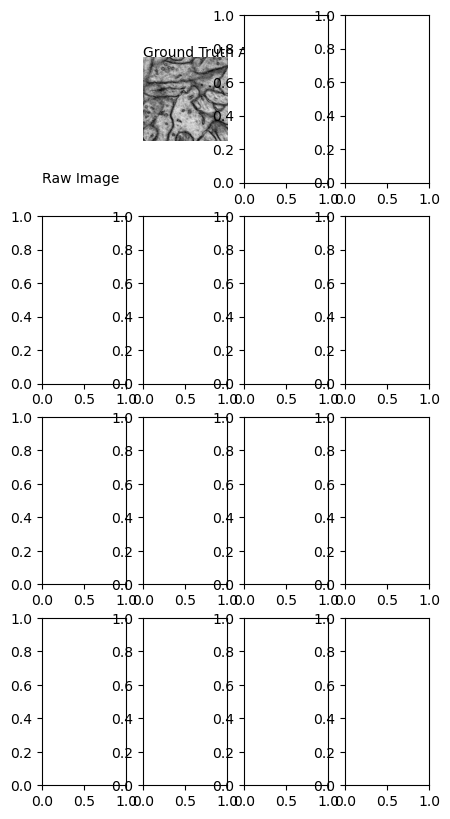

In [16]:
compare_models([
  ("autoseg/user_configs/anton/baselines/unet/1", "Baseline UNet", [0, 216, 216]),
  #("autoseg/user_configs/anton/baselines/unet/2", "Baseline UNet", [0, 216, 216]),
  #("autoseg/user_configs/anton/baselines/unet_lsd/1", "UNet with LSD", [0, 216, 216]),
  #("autoseg/user_configs/anton/baselines/unet_lsd/2", "Unet with LSD", [0, 216, 216]),
  #("autoseg/user_configs/anton/baselines/unet_lsd_ln_act/1", "Unet++ with LSD", [0, 216, 216]),
  #("autoseg/user_configs/anton/baselines/unet_lsd_ln_act/2", "UNet++ with LSD", [0, 216, 216]),
  #("autoseg/user_configs/anton/baselines/unetr/1", "UNETR", [0, 0, 0]),
  #("autoseg/user_configs/anton/baselines/unetr/2", "UNETR", [0, 0, 0])
])